In [1]:
%load_ext autoreload

In [2]:
%autoreload
import eitx

In [3]:
import numpy as np
import pandas as pd
import dolfinx
import ufl
import scipy as sp
from matplotlib import pyplot as plt

# Setup

In [4]:
L=16
perc=0.5
electrodes = eitx.Electrodes(L,perc,0)

mesh_refining = 0.3 #scaling factor for all domain refinement
bdr_refining = 0.5 # scaling factor for border refining

mesh_object = eitx.MeshClass(electrodes,mesh_refining,bdr_refining)
mesh_dir = mesh_object.mesh
z_values = np.full(L,0.0025+0.0025j)
dir_problem = eitx.DirectProblem(mesh_object, z_values)
I_all = eitx.current_method(L,15,method=2,value=1)

eitx.plot_mesh(mesh_dir)



Error   : Gmsh has not been initialized


Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.090404s, CPU 0.040068s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 0.213241s, CPU 0.215504s)
Info    : 2987 nodes 5173 elements


# Consistency tests

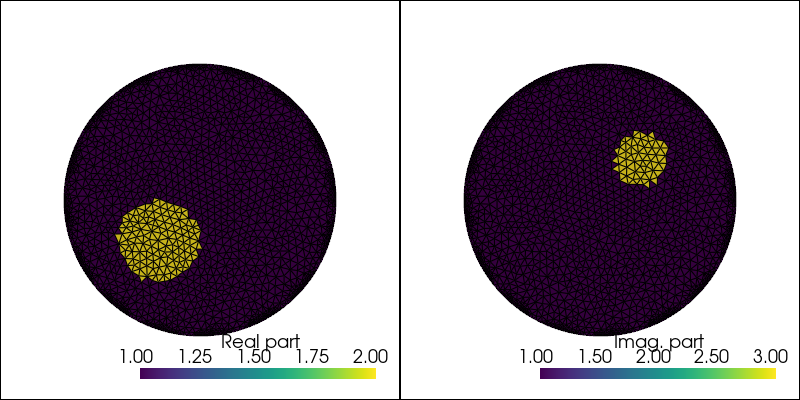

In [5]:
V0 = dir_problem.V0
x = ufl.SpatialCoordinate(mesh_dir)

#defining gamma
def gamma_locator(x):
  return (x[0]+0.3)**2 + (x[1]+0.3)**2<=0.3**2
def gamma_locator_2(x):
  return (x[0]-0.3)**2 + (x[1]-0.3)**2<=0.2**2
gamma_sol = dolfinx.fem.Function(V0)
gamma_sol_cells = gamma_locator(V0.tabulate_dof_coordinates().T).astype(int)
gamma_sol_cells2 = gamma_locator_2(V0.tabulate_dof_coordinates().T).astype(int)
gamma_sol.x.array[:] = 1 + 1j + gamma_sol_cells + 2j*gamma_sol_cells2

# gamma_sol = dolfinx.fem.Function(V0)
# expr = 1+1j+ ufl.exp(-(x[0]**2+x[1]**2)/0.2)
# gamma_sol.interpolate(dolfinx.fem.Expression(expr,V0.element.interpolation_points()))

# gamma_sol = dolfinx.fem.Function(V0)
# expr = 1+1j+ ufl.exp(-(x[0]**2+x[1]**2)/0.2) + 1j*ufl.exp(-(x[0]**2+x[1]**2)/0.2)
# gamma_sol.interpolate(dolfinx.fem.Expression(expr,V0.element.interpolation_points()))

eitx.plot_indicator_function(gamma_sol)

In [6]:
#solving direct problem
dir_problem.set_problem(gamma_sol)
A_op = dir_problem.A_op

In [7]:
# Solving by direct solver (sp.sparse.linalg.spsolve)
u_list_dir, U_list_dir = dir_problem.solve_problem_current(I_all)

In [8]:
A_op = dir_problem.A_op
A_np = dir_problem.A_np
N = dir_problem.N
L = dir_problem.L
V = dir_problem.V

In [9]:
## solving by iterative solver (sp.sparse.linalg.cg)
u_list_iter = []
u_array_list = []
U_list_iter = []

l = len(I_all)

for k in range(l):
  b = np.block([np.zeros(N,dtype=complex),I_all[k]])
  u_nest, exit_code = sp.sparse.linalg.cg(A_op,A_np.T.conj()@b,rtol=1e-10) #Solve A^*Au = b
  u_array, U_array = u_nest[:N], u_nest[N:] #splitting array
  
  print("Exit code", exit_code)
  # translating solutions (U = (U1 + S/L,...,UL + S/L)), with S = U1+...+UL
  S = U_array.sum()
  U_array -= S/L
  u_array -= S/L

  u_array_list.append(u_array)
  U_list_iter.append(U_array)

for u_array in u_array_list:
  u = dolfinx.fem.Function(V)
  u.x.array[:] = u_array
  u_list_iter.append(u)


Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0


KeyboardInterrupt: 

Error norm 1.7908194966743024e-07


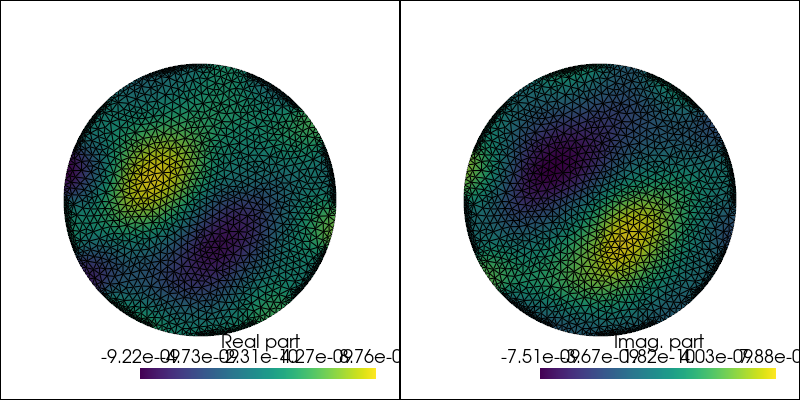

Error norm 2.0904189378496712e-07


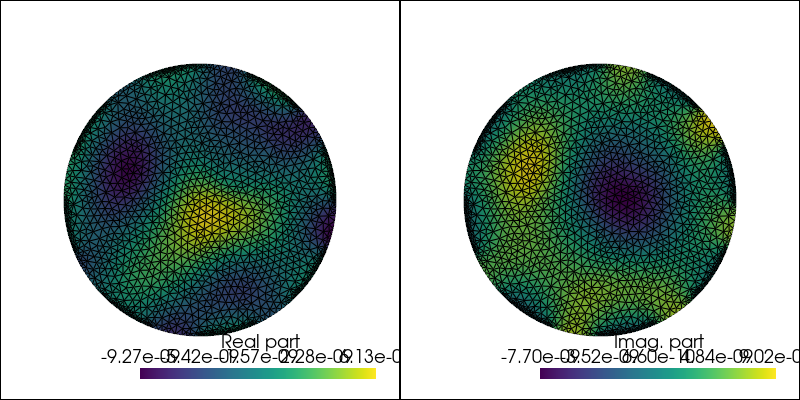

Error norm 2.225093384816036e-07


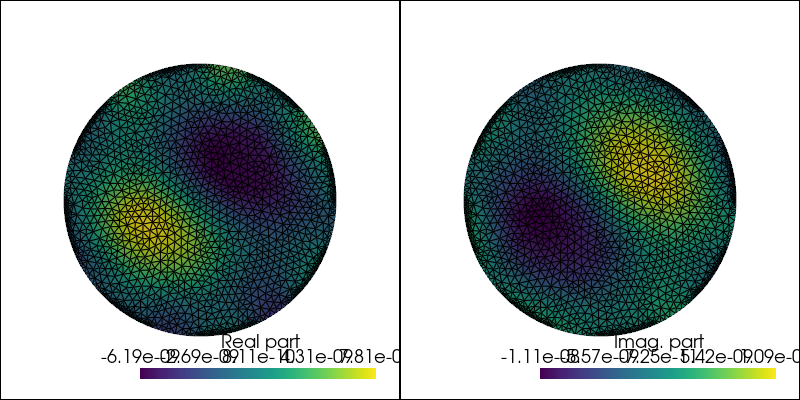

Error norm 1.2754591015098319e-07


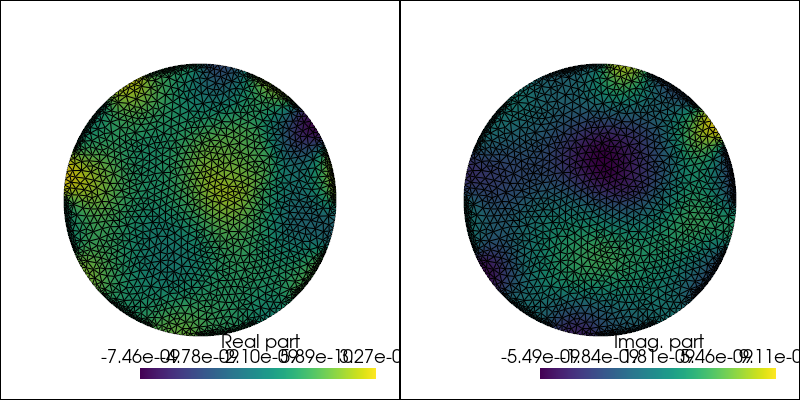

In [ ]:
err_list = [dolfinx.fem.Function(V) for k in range(l)]
for u_dir,u_iter,err in zip(u_list_dir,u_list_iter,err_list):
    err.x.array[:] = u_dir.x.array-u_iter.x.array
    print("Error norm", np.linalg.norm(err.x.array))
    # eitx.plot_tent_function(err)

In [ ]:
for U_dir, U_iter in zip(U_list_dir, U_list_iter):
    print("Error norm:", np.linalg.norm(U_dir-U_iter))

Error norm: 5.109351272244025e-09
Error norm: 3.0054194382703845e-09
Error norm: 8.08881152650815e-09
Error norm: 4.811581605492128e-09


#### Solving direct problem

Currents:
$$
I_1 = [1 , -1 ,0\; \dots 0] \\
I_2 = [0,1,-1, \dots, 0]\\
\vdots
$$

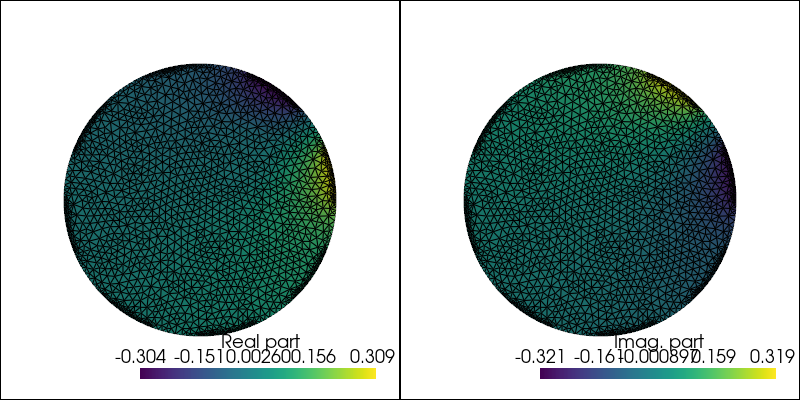

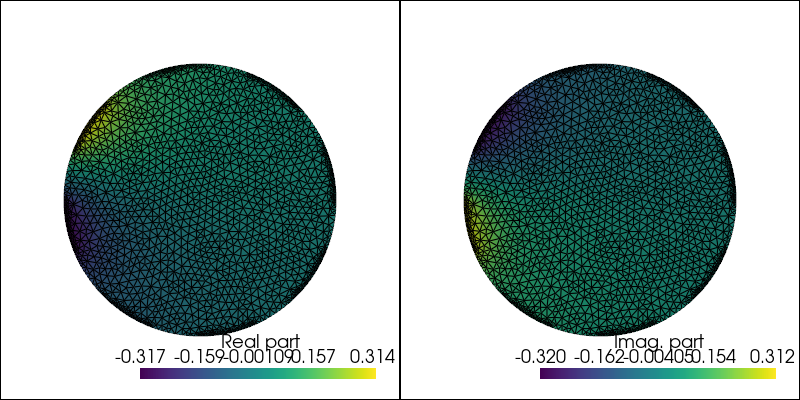

In [55]:
for k in range(l):
  eitx.plot_tent_function(u_list_iter[k])

#### Test 1: integral x current
$$
\int_{e_j} \gamma \frac{\partial u}{\partial \eta} dS = I_j
$$

In [56]:
int_array = []
I_all_array = np.array(I_all)
ds = dir_problem.ds
n = ufl.FacetNormal(mesh_dir)
for k in range(l):
  int_k_list = [ ]
  for j in range(L):
    form = dolfinx.fem.form(gamma_sol * ufl.inner(ufl.grad(u_list_dir[k]),n) * ds(j))
    value = dolfinx.fem.assemble_scalar(form)
    int_k_list.append(value)

  int_array.append(int_k_list)

int_array = np.array(int_array)

for k in range(l):
  print("Current",k)
  int_df = pd.DataFrame({"Currents Array (I)":I_all_array[k], "Integral Array": int_array[k], "Error":I_all_array[k]-int_array[k]})
  print(int_df.head(n=L))
  # print("Currents array: ",I)
  # print("Integral array:", int_array)
  # print("Error:", I-int_array)

Current 0
   Currents Array (I)      Integral Array               Error
0                 1.0  0.886605+0.029523j  0.113395-0.029523j
1                -1.0 -0.890791-0.029181j -0.109209+0.029181j
2                 0.0 -0.002921+0.000940j  0.002921-0.000940j
3                 0.0 -0.001101-0.000039j  0.001101+0.000039j
4                 0.0 -0.000176+0.000147j  0.000176-0.000147j
5                 0.0  0.000276-0.000188j -0.000276+0.000188j
6                 0.0  0.000579-0.000161j -0.000579+0.000161j
7                 0.0  0.003204-0.000812j -0.003204+0.000812j
Current 1
   Currents Array (I)      Integral Array               Error
0                 0.0  0.003305-0.000701j -0.003305+0.000701j
1                 1.0  0.890150+0.029034j  0.109850-0.029034j
2                -1.0 -0.885756-0.028342j -0.114244+0.028342j
3                 0.0 -0.004537+0.000162j  0.004537-0.000162j
4                 0.0 -0.000718+0.000297j  0.000718-0.000297j
5                 0.0 -0.000011-0.000099j  0.00001

In [57]:
fig,ax = plt.subplots(l,1,figsize=(10,20))

for k in range(l):
  ax[k].plot(int_array[k].real, label="Integrated",marker='.')
  ax[k].plot(I_all[k], label="I array",marker='.')
  ax[k].legend()
  ax[k].set_ylabel("Current (I)")
  ax[k].set_xlabel("Electrode")
  ax[k].set_title(f"Current I_{k}")

fig.tight_layout()
plt.show()

#### Test 2: flux in gaps

Verifying plot of $\gamma \nabla u \cdot \eta$ on boundary

Couldn't use the fenics projections, computing it using analytic geometry stuff.

Getting index of triangles with facet on boundary

Idea from https://fenicsproject.discourse.group/t/define-a-boundary-from-dg-elements/5723/2

In [58]:
# The code below gets all triangles with a facet (edge) contained in boundary.
mesh_dir.topology.create_connectivity(1, mesh_dir.topology.dim)
facet_to_cell = mesh_dir.topology.connectivity(1, mesh_dir.topology.dim)
def boundary_locator(x):
    return np.isclose(x[0]**2+x[1]**2, 1)

boundary_facets = dolfinx.mesh.locate_entities(mesh_dir, 1, boundary_locator)
boundary_cells = []
for facet in boundary_facets:
    boundary_cells.append(facet_to_cell.links(facet))
boundary_cells = np.hstack(boundary_cells)

In [59]:
adjacency_list = mesh_dir.topology.connectivity(2,0)
mesh_dir_vertex_index_list = []
for i in range(len(adjacency_list)):
  mesh_dir_vertex_index_list.append(adjacency_list.links(i))

cells_coordinates_list = []
for cell_vertex_index in mesh_dir_vertex_index_list:
  cells_coordinates_list.append(mesh_dir.geometry.x[cell_vertex_index][:,:2])

#Compute grad(u_func)
# gradu_list = []

flux_list = []
for k in range(l):
  flux_k_list = []

  for idx in mesh_dir_vertex_index_list:
    cell_coord = mesh_dir.geometry.x[idx][:,:2]
    system_array = np.concatenate((cell_coord,np.ones(3).reshape(3,1)),axis=1)
    u_t = u_list_iter[k].x.array[idx]
    plane_coef = np.linalg.solve(system_array, u_t)
    gradu = plane_coef[:2]
    # gradu_x, gradu_y = plane_coef[0],plane_coef[1]

    #checks outer segment, compute normal vector pointing outward the domain
    idx_interior_point = np.argmin(np.linalg.norm(cell_coord,axis=1)) #idx of vertex on interior (closer to 0)
    interior_point = cell_coord[idx_interior_point]
    bdr_point_A, bdr_point_B = np.delete(cell_coord,[idx_interior_point],axis=0)
    AB = bdr_point_B - bdr_point_A
    AI = interior_point - bdr_point_A
    t = np.vdot(AB,AI)/np.vdot(AB,AB)
    projAB = bdr_point_A + t*AB
    N = projAB - interior_point
    normal = N/np.linalg.norm(N)

    # gamma_x = gamma.x.array[idx]
    gamma_x = 1

    flux_k_list.append(gamma_x * (np.vdot(normal,gradu)))

  flux_k_array = np.array(flux_k_list)
  flux_list.append(flux_k_array)

In [60]:
#get angle of cell in each
dofs_coordinates = V0.tabulate_dof_coordinates()
x_bdr = dofs_coordinates[boundary_cells][:,0]
y_bdr = dofs_coordinates[boundary_cells][:,1]
theta = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))

In [61]:
#checks if angle is in some electrode
electrode_marker = []
for angle in theta:
  inElectrode = False
  for (theta_i,theta_f) in electrodes.position:
    if theta_i<=angle and angle<=theta_f:
      inElectrode = True
      break
  electrode_marker.append(inElectrode)

electrode_marker = np.array(electrode_marker)

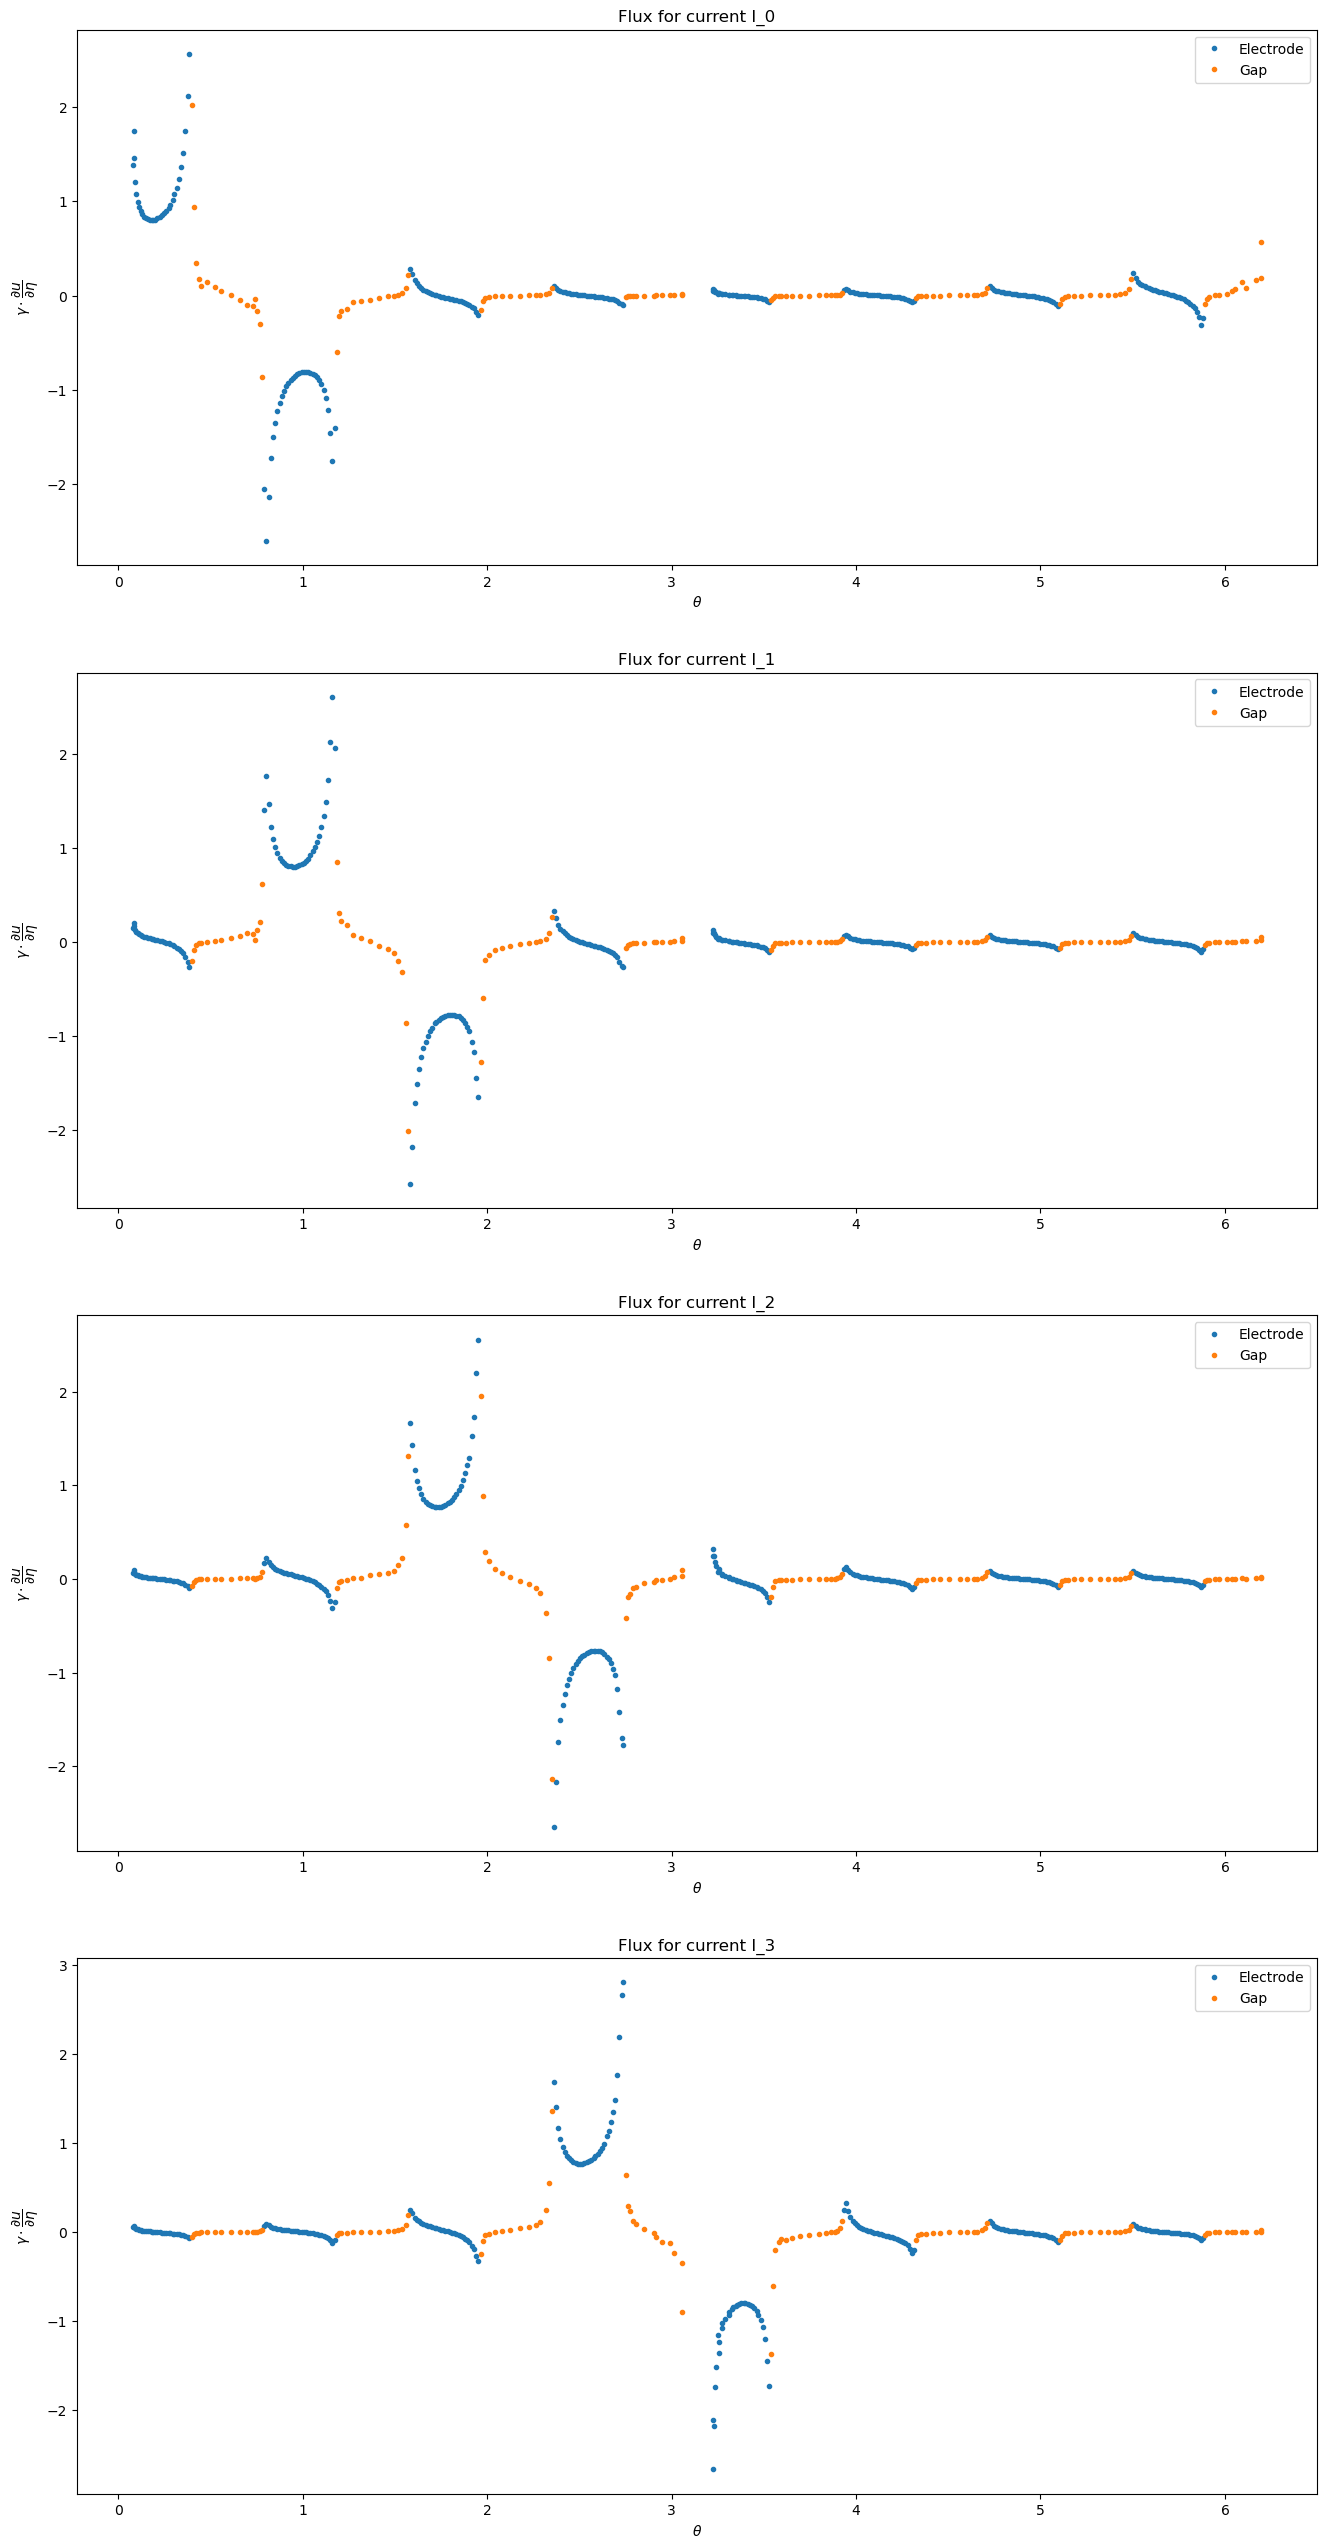

In [62]:
fig,ax = plt.subplots(l,1,figsize=(16,32))


for k in range(l):
  flux_array = flux_list[k]
  theta_cells_in_electrode = theta[electrode_marker]
  theta_cells_out_electrode = theta[~electrode_marker]
  flux_in_electrode = flux_array[boundary_cells][electrode_marker]
  flux_out_electrode = flux_array[boundary_cells][~electrode_marker]


  ax[k].plot(theta_cells_in_electrode,flux_in_electrode.real,marker='.',linestyle='',label="Electrode")
  ax[k].plot(theta_cells_out_electrode,flux_out_electrode.real,marker='.',linestyle='',label='Gap')
  ax[k].set_xlabel("$\\theta$")
  ax[k].set_ylabel("$\gamma \cdot \dfrac{\partial u}{\partial \eta}$")
  ax[k].legend()
  ax[k].set_title(f'Flux for current I_{k}')

plt.show()

#### Test 3: potential in electrodes

Testing if
$$
U_j = u|_{e_j} + z_j \gamma \frac{\partial u}{\partial \eta}
$$


As $u$ is defined on the vertices and $\gamma \frac{\partial u}{\partial \eta}$ is constant in each edge, needs to chose which vertex and adjacent facet to evaluate.

Getting the following:
- order vertices and facets by angle;
- chose $u_j$ and $\gamma_j$ in the order set above.



In [63]:
mesh = mesh_dir
#create connection
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
boundary_facets = dolfinx.mesh.exterior_facet_indices(mesh.topology)
boundary_dofs_index_array = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim-1, boundary_facets) #array with the vertices index

#gets x and y coordinates for the boundary
V_dofs_coordinates = V.tabulate_dof_coordinates()
x_bdr = V_dofs_coordinates[boundary_dofs_index_array][:,0]
y_bdr = V_dofs_coordinates[boundary_dofs_index_array][:,1]
theta = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))
sorted_theta_vtx_index = np.argsort(theta)

#get angle of cell in each
V0_dofs_coordinates = V0.tabulate_dof_coordinates()
x_bdr = V0_dofs_coordinates[boundary_cells][:,0]
y_bdr = V0_dofs_coordinates[boundary_cells][:,1]
theta_cells = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))
sorted_theta_cll_index = np.argsort(theta_cells)


In [64]:
z_value = z_values[0]
sorted_bdr_vtx_idx = boundary_dofs_index_array[sorted_theta_vtx_index]
sorted_bdr_cll_idx = boundary_cells[sorted_theta_cll_index]
U_star_list = []
for k in range(l):
  flux_array = flux_list[k]
  U_star = u_list_iter[k].x.array[sorted_bdr_vtx_idx] + z_value*flux_array[sorted_bdr_cll_idx]
  U_star_list.append(U_star)

In [65]:
t = theta[sorted_theta_vtx_index]
fig,axs = plt.subplots(L,l,figsize=(20,30))

for k in range(l):
  U_star = U_star_list[k]
  U_array = U_list_iter[k]

  for j in range(L):
    theta_i,theta_f = electrodes.position[j]
    theta_j_idx = np.logical_and(t>=theta_i,t<=theta_f)#index of theta in electrode j
    axs[j][k].plot(t[theta_j_idx],U_star.real[theta_j_idx],label=f"U*{j}",linestyle='',marker='.')
    axs[j][k].axhline(U_array[j].real,label=f'U{j}',linestyle='--')
    axs[j][k].legend()
    # axs[j].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])

    # axs[1].plot(t,f(t),label="exact")
    # axs[1].plot(t,u_bdr_imag_array,label="calculated")
    # axs[1].set_title("imaginary part")
    # axs[1].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])
fig.suptitle("$U^*$ computed values compared to $U$ array values")
fig.supylabel("Electrodes")
fig.supxlabel("Currents")

fig.tight_layout()

plt.show()

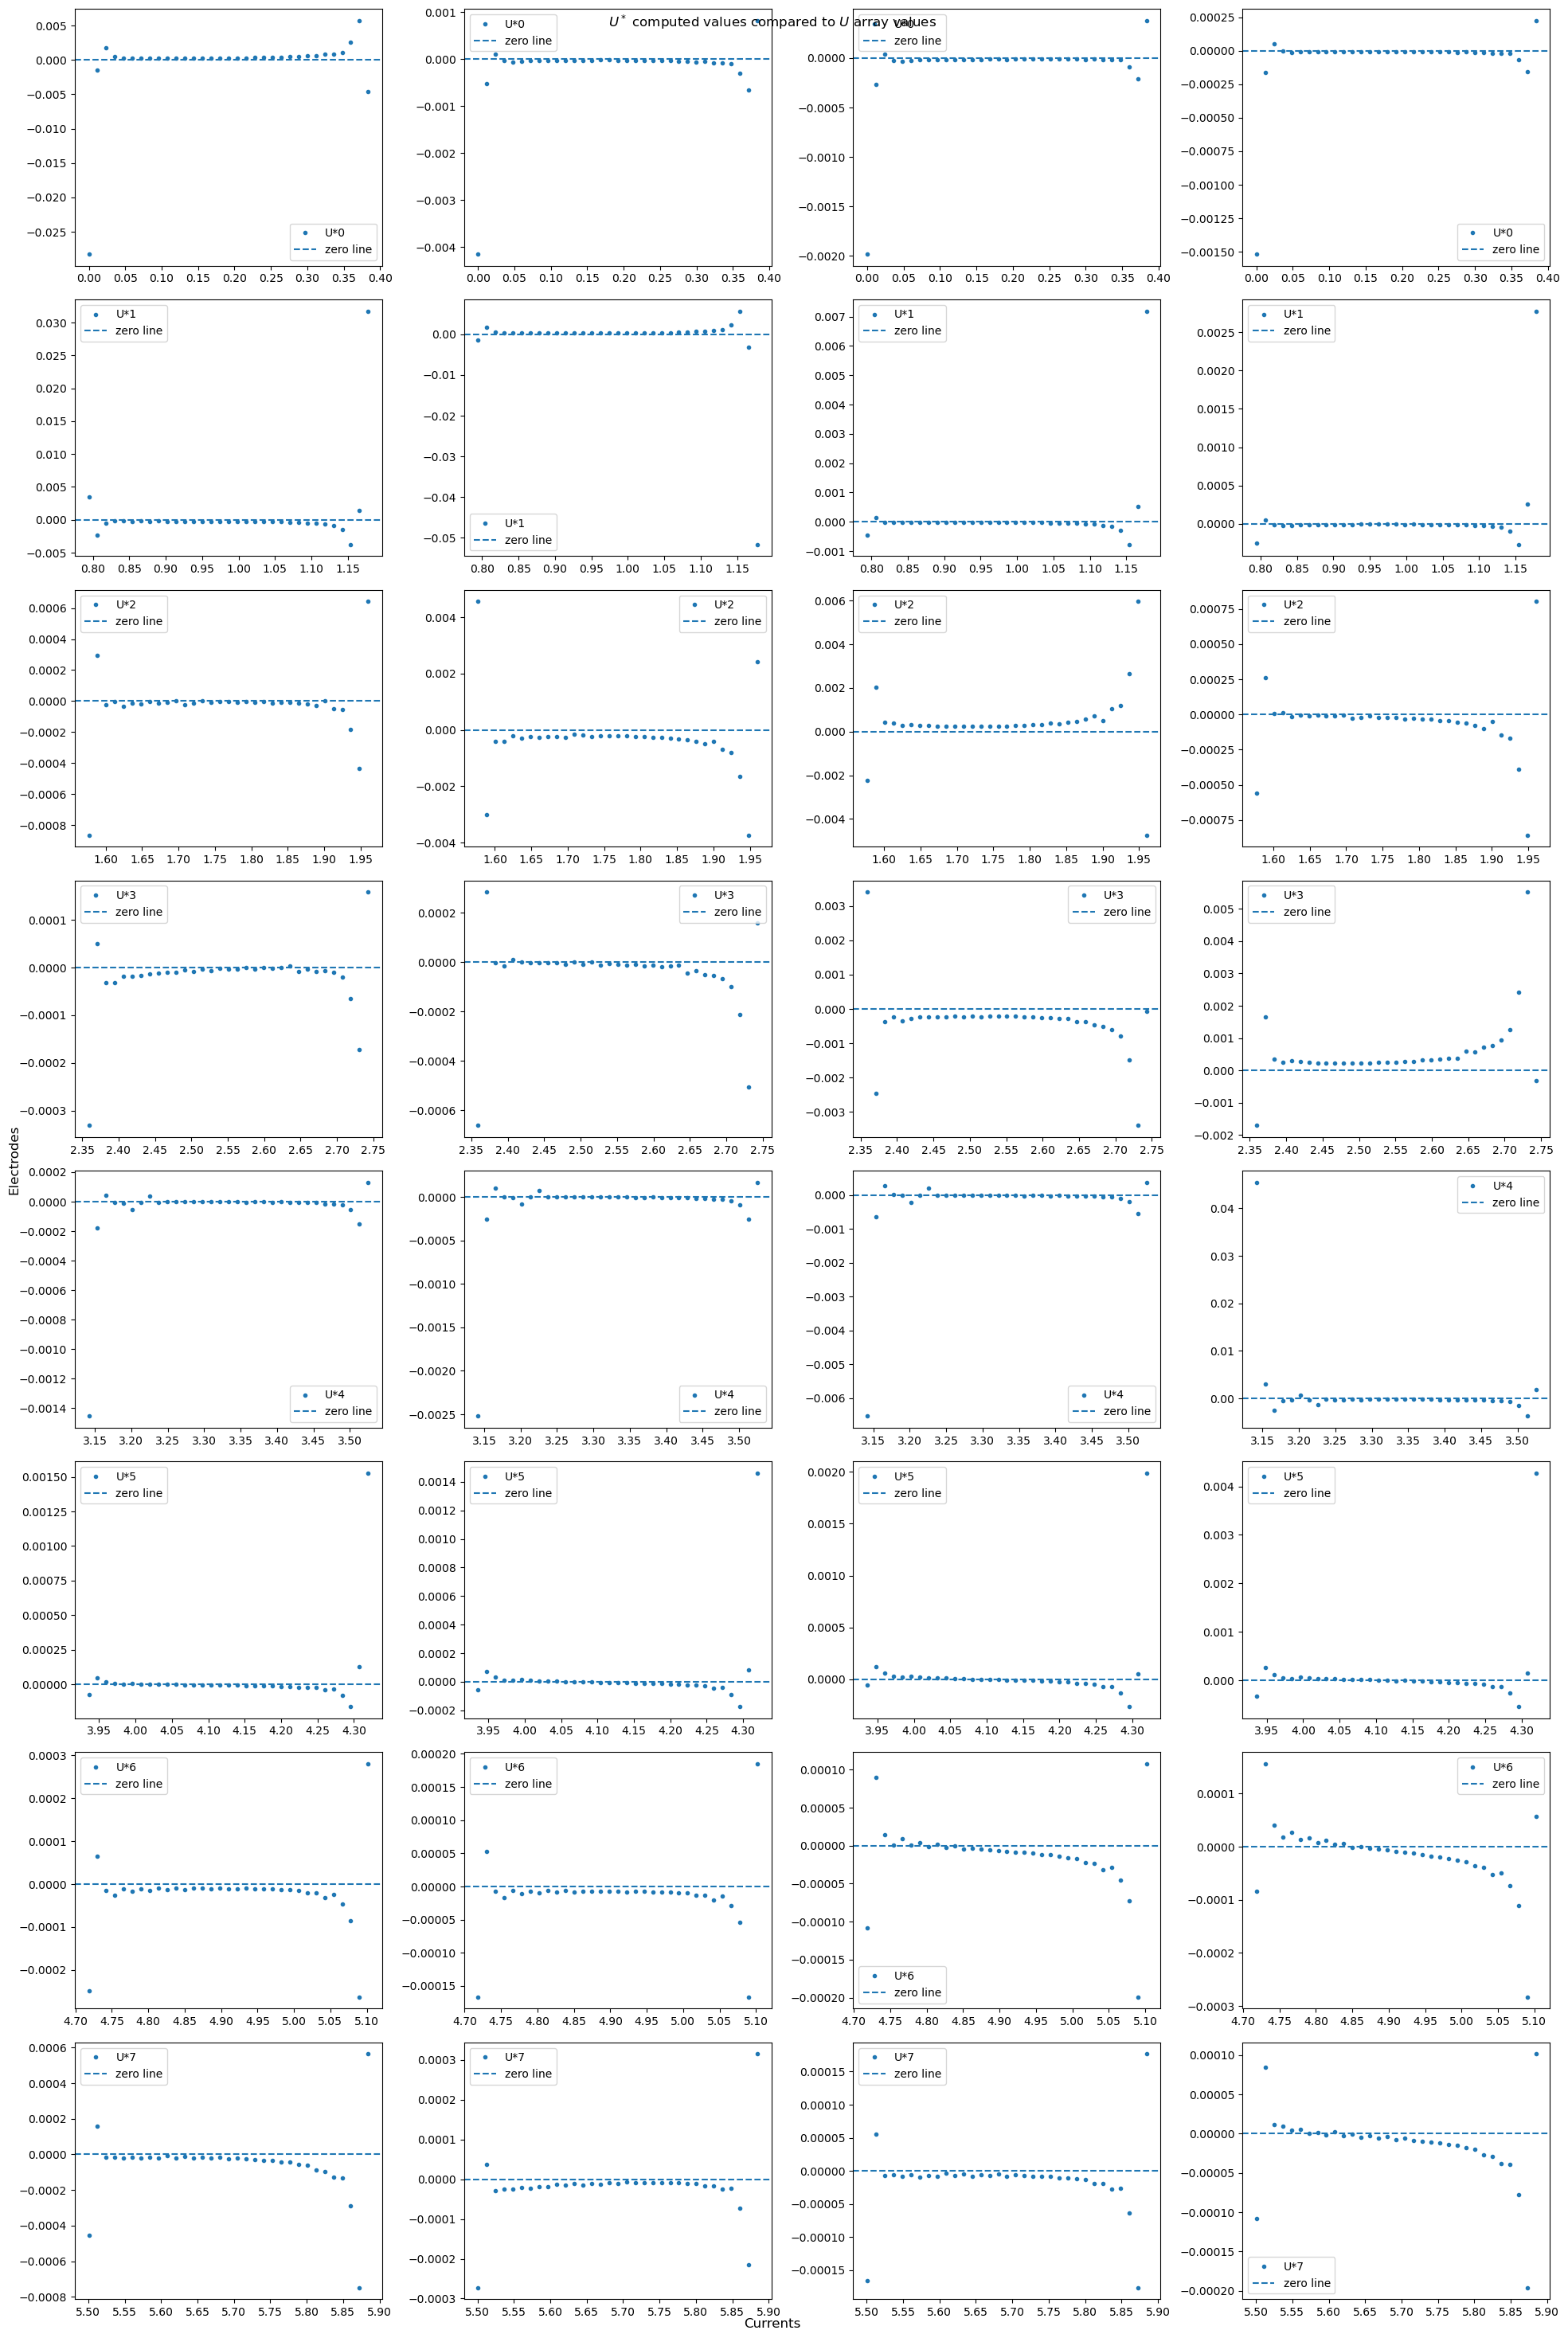

In [66]:
t = theta[sorted_theta_vtx_index]
fig,axs = plt.subplots(L,l,figsize=(20,30))

for k in range(l):
  U_star = U_star_list[k]
  U_array = U_list_dir[k]

  for j in range(L):
    theta_i,theta_f = electrodes.position[j]
    theta_j_idx = np.logical_and(t>=theta_i,t<=theta_f)#index of theta in electrode j
    # axs[j][k].plot(t[theta_j_idx],U_star.real[theta_j_idx],label=f"U*{j}",linestyle='',marker='.')
    # axs[j][k].axhline(U_array[j].real,label=f'U{j}',linestyle='--')
    axs[j][k].plot(t[theta_j_idx],U_star.real[theta_j_idx]-U_array[j].real,label=f"U*{j}",linestyle='',marker='.')
    axs[j][k].axhline(0,label=f'zero line',linestyle='--')
    axs[j][k].legend()
    # axs[j].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])

    # axs[1].plot(t,f(t),label="exact")
    # axs[1].plot(t,u_bdr_imag_array,label="calculated")
    # axs[1].set_title("imaginary part")
    # axs[1].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])
fig.suptitle("$U^*$ computed values compared to $U$ array values")
fig.supylabel("Electrodes")
fig.supxlabel("Currents")

fig.tight_layout()

plt.show()

# Comparing parameters

Testing different `rtol` parameter for ``cg` method.

In [10]:
A_op = dir_problem.A_op
A_np = dir_problem.A_np
N = dir_problem.N
L = dir_problem.L
V = dir_problem.V

In [11]:
import time

In [12]:
r_tol_list = [1e-5,1e-8,1e-10,1e-12,1e-14]
## solving by iterative solver (sp.sparse.linalg.cg)

l = len(I_all)
for r_tol in r_tol_list:
  u_list_iter = []
  u_array_list = []
  U_list_iter = []
  print("r_tol=",r_tol,'\n')
  t1 = time.time()
  for k in range(l):
    b = np.block([np.zeros(N,dtype=complex),I_all[k]])
    u_nest, exit_code = sp.sparse.linalg.cg(A_op,A_np.T.conj()@b,rtol=r_tol) #Solve A^*Au = b
    u_array, U_array = u_nest[:N], u_nest[N:] #splitting array
    
    print("Exit code", exit_code)
    # translating solutions (U = (U1 + S/L,...,UL + S/L)), with S = U1+...+UL
    S = U_array.sum()
    U_array -= S/L
    u_array -= S/L

    u_array_list.append(u_array)
    U_list_iter.append(U_array)

  t2=time.time()
  print("solved in",t2-t1,"seconds")
  for u_array in u_array_list:
    u = dolfinx.fem.Function(V)
    u.x.array[:] = u_array
    u_list_iter.append(u)

  print("\nu func comparison")
  err_list = [dolfinx.fem.Function(V) for k in range(l)]
  for u_dir,u_iter,err in zip(u_list_dir,u_list_iter,err_list):
      err.x.array[:] = u_dir.x.array-u_iter.x.array
      print("Error norm", np.linalg.norm(err.x.array))
      # eitx.plot_tent_function(err)

  print("\nU array comparison")
  for U_dir, U_iter in zip(U_list_dir, U_list_iter):
    print("Error norm:", np.linalg.norm(U_dir-U_iter))

r_tol= 1e-05 

Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
Exit code 0
solved in 11.836745262145996 seconds

u func comparison
Error norm 1.3747637852971482
Error norm 1.3394243684354192
Error norm 1.3758394305903345
Error norm 1.4177895018175133
Error norm 1.4418371894083701
Error norm 1.4573376207783424
Error norm 1.3993996062234797
Error norm 1.3923568794414471
Error norm 1.3260984489313465
Error norm 1.2834067334563237
Error norm 1.3135753031798678
Error norm 1.3331755312952243
Error norm 1.4434064036450143
Error norm 1.4636643218042056
Error norm 1.463343932980745

U array comparison
Error norm: 0.13122701679295734
Error norm: 0.12775436540567964
Error norm: 0.13104697292985043
Error norm: 0.13486763886982975
Error norm: 0.13713410588238742
Error norm: 0.13876368740312403
Error norm: 0.13327865356717064
Error norm: 0.13232180052842565
Error norm: 0.1261521725

# Solving inverse problem

In [8]:
mesh_refining = 0.6 #scaling factor for all domain refinement
bdr_refining = 0.8 # scaling factor for border refining
mesh_inv_object = eitx.MeshClass(electrodes,mesh_refining,bdr_refining)
mesh = mesh_inv_object.mesh

Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.0619214s, CPU 0.052191s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 0.123931s, CPU 0.12452s)
Info    : 1748 nodes 2695 elements


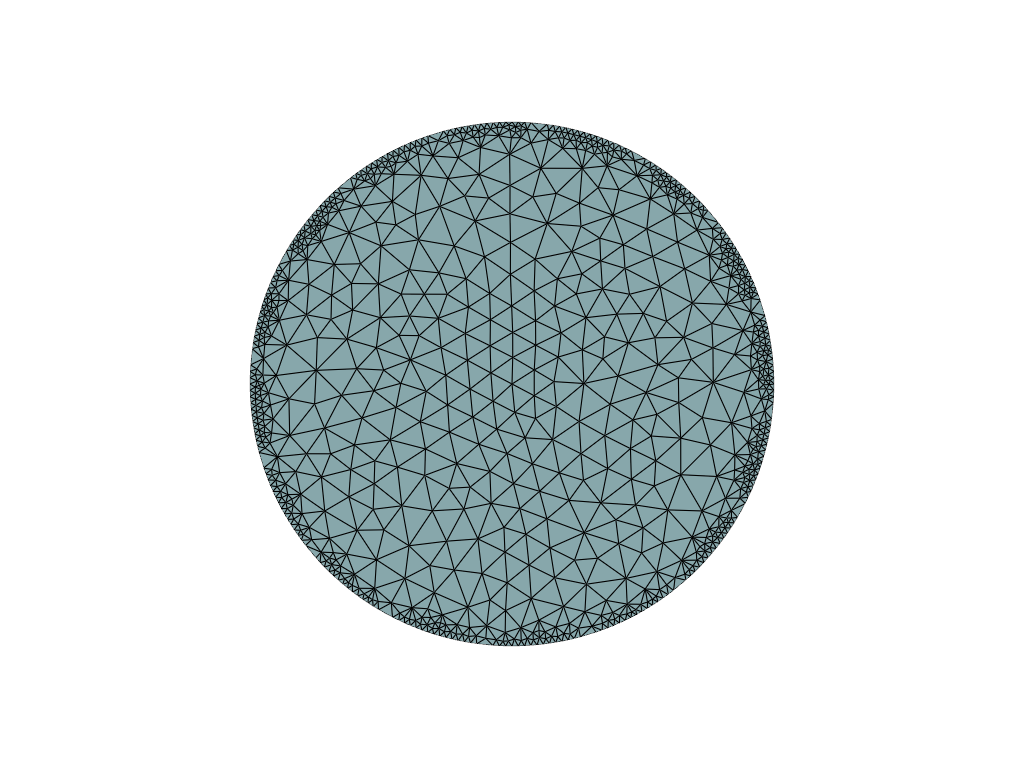

In [9]:
eitx.plot_mesh(mesh)

## Levenberg-Marquardt

In [10]:
%autoreload
import eitx
inv_problem = eitx.InverseProblem(mesh_inv_object, z_values, I_all)

In [11]:
solverconfig_dict= { 
    #General Parameters
    "inner_method": "Tikhonov",
    "step_limit": 10,
    "tau": 1,
    "noise_level": 0,
    "weight_value": True,
    "innerstep_limit": 1,
    "Tik_c0": 1e-7,
    "Tik_q": 1,
    #General newton method parameters
    "mu_i":0.85,
    "mu_max":0.999,
    "nu":0.97,
    "R":0.97,
}
inv_problem.set_solverconfig(**solverconfig_dict)
inv_problem.set_answer(gamma_sol)

In [12]:
U_list = U_list_dir

In [13]:
gamma, res_array, err_array = inv_problem.solve_inverse(U_list)


starting outer step 1
Inner iteration finished with 1 iterations
starting outer step 2
Inner iteration finished with 1 iterations
starting outer step 3
Inner iteration finished with 1 iterations
starting outer step 4
Inner iteration finished with 1 iterations
starting outer step 5
Inner iteration finished with 1 iterations
starting outer step 6
Inner iteration finished with 1 iterations
starting outer step 7
Inner iteration finished with 1 iterations
starting outer step 8
Inner iteration finished with 1 iterations
starting outer step 9
Inner iteration finished with 1 iterations
starting outer step 10
Inner iteration finished with 1 iterations


In [14]:
err_array = np.array(err_array)
res_array = np.array(res_array)

Text(0.5, 0.98, 'Comparação')

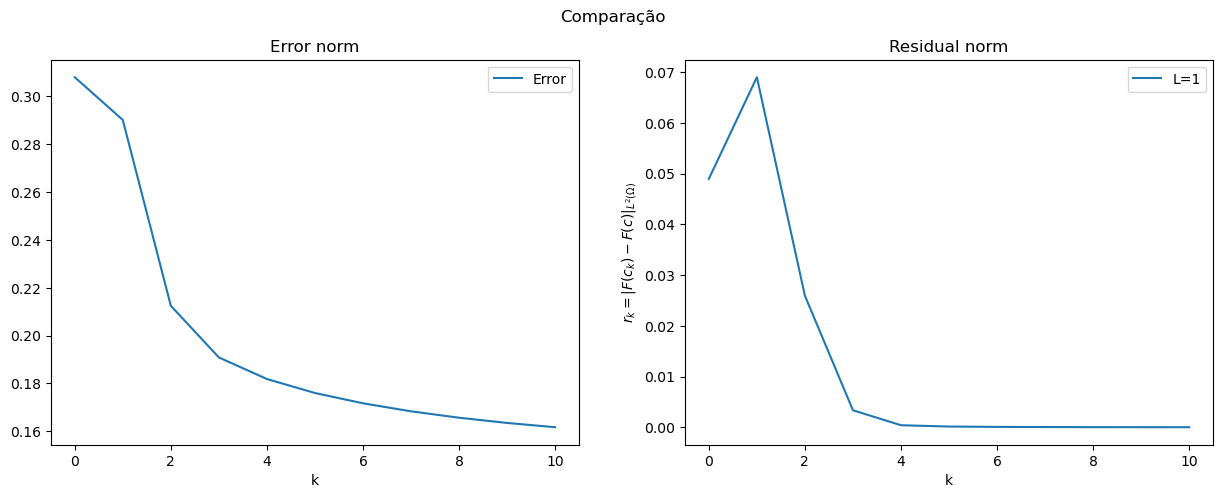

In [15]:
gamma_norm = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(inv_problem.gamma_inv, inv_problem.gamma_inv)*ufl.dx)).real**0.5
U_norm = np.linalg.norm(np.array(U_list).flatten())

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(err_array/gamma_norm,label='Error')
ax[0].set_title("Error norm")
ax[0].set_xlabel("k")
# ax[0].set_yscale("log")
ax[0].legend()

ax[1].plot(res_array/U_norm,label ='L=1')
ax[1].set_title("Residual norm")
ax[1].set_ylabel("$r_k = \|F(c_k) - F(c)\|_{L^2(\Omega)}$")
ax[1].set_xlabel("k")
# ax[1].set_yscale("log")
ax[1].legend()

fig.suptitle("Comparação")

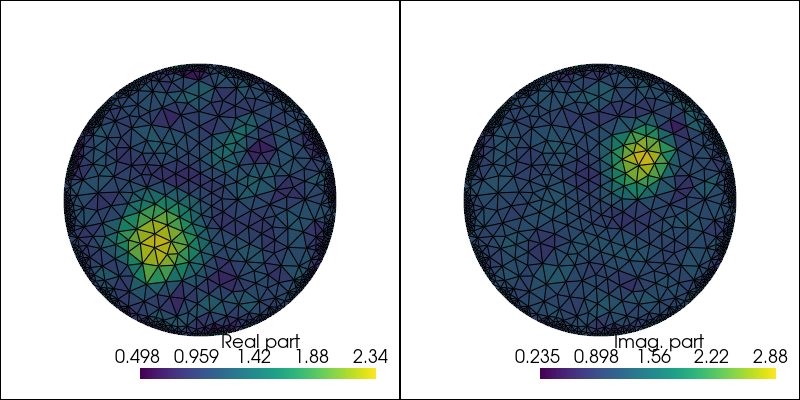

In [16]:
eitx.plot_indicator_function(gamma)

## REGINN-Gradiente

In [32]:
%autoreload
import eitx
inv_problem = eitx.InverseProblem(mesh_inv_object, z_values, I_all)

In [17]:
solverconfig_dict= { 
    #General Parameters
    "step_limit": 20,
    "tau": 1,
    "noise_level": 0,
    "weight_value": True,
    "innerstep_limit": 40,
    "land_a": 0.3,
    #General newton method parameters
    "mu_i":0.85,
    "mu_max":0.999,
    "nu":0.97,
    "R":0.97,
}
inv_problem.set_solverconfig(**solverconfig_dict)
inv_problem.set_answer(gamma_sol)

In [19]:
gamma, res_array, err_array = inv_problem.solve_inverse(U_list)

starting outer step 1
Inner iteration finished with 2 iterations
starting outer step 2
Inner iteration finished with 2 iterations
starting outer step 3
Inner iteration finished with 2 iterations
starting outer step 4
Inner iteration finished with 2 iterations
starting outer step 5
Inner iteration finished with 2 iterations
starting outer step 6
Inner iteration finished with 2 iterations
starting outer step 7
Inner iteration finished with 2 iterations
starting outer step 8
Inner iteration finished with 2 iterations
starting outer step 9
Inner iteration finished with 2 iterations
starting outer step 10
Inner iteration finished with 2 iterations
starting outer step 11
Inner iteration finished with 2 iterations
starting outer step 12
Inner iteration finished with 2 iterations
starting outer step 13
Inner iteration finished with 2 iterations
starting outer step 14
Inner iteration finished with 2 iterations
starting outer step 15
Inner iteration finished with 2 iterations
starting outer step

In [20]:
err_array = np.array(err_array)
res_array = np.array(res_array)

Text(0.5, 0.98, 'Comparação')

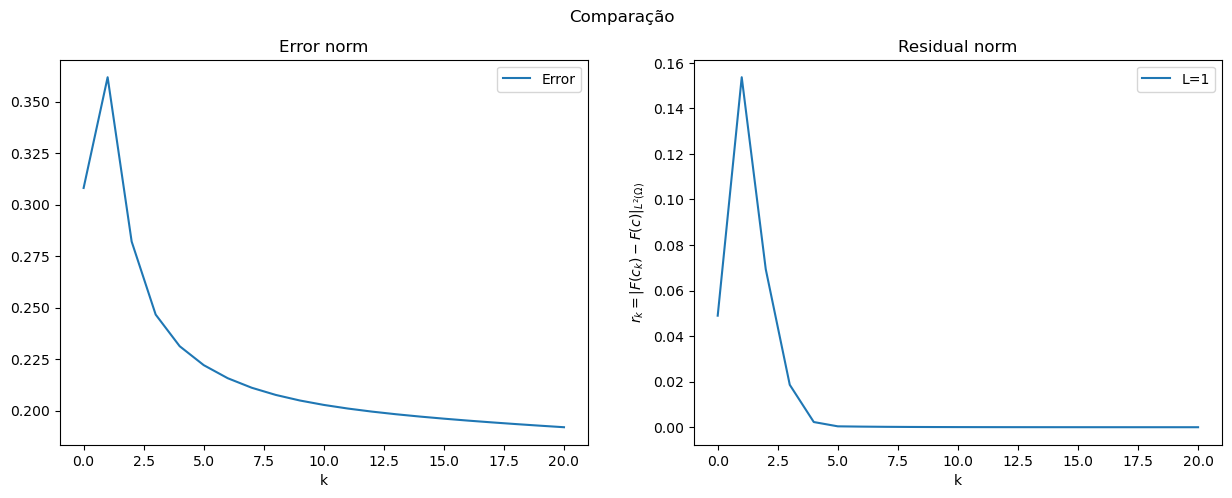

In [21]:
gamma_norm = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(inv_problem.gamma_inv, inv_problem.gamma_inv)*ufl.dx)).real**0.5
U_norm = np.linalg.norm(np.array(U_list).flatten())

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(err_array/gamma_norm,label='Error')
ax[0].set_title("Error norm")
ax[0].set_xlabel("k")
# ax[0].set_yscale("log")
ax[0].legend()

ax[1].plot(res_array/U_norm,label ='L=1')
ax[1].set_title("Residual norm")
ax[1].set_ylabel("$r_k = \|F(c_k) - F(c)\|_{L^2(\Omega)}$")
ax[1].set_xlabel("k")
# ax[1].set_yscale("log")
ax[1].legend()

fig.suptitle("Comparação")

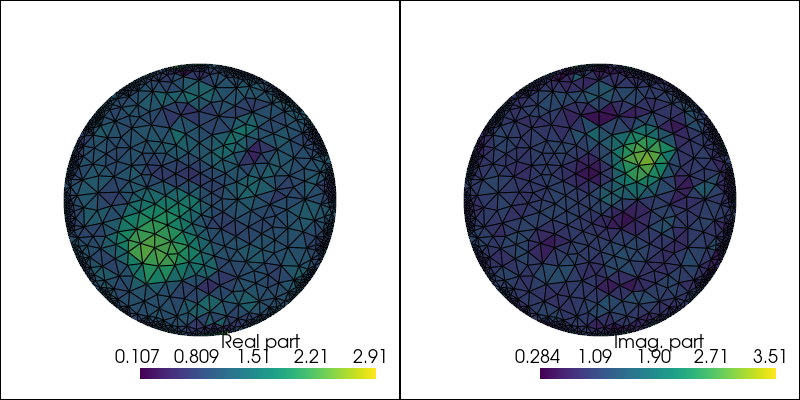

In [22]:
eitx.plot_indicator_function(gamma)

## REGINN-Tikhonov

In [23]:
%autoreload
import eitx
inv_problem = eitx.InverseProblem(mesh_inv_object, z_values, I_all)

In [24]:
solverconfig_dict= { 
    #General Parameters
    "inner_method": "Tikhonov",
    "step_limit": 10,
    "tau": 1,
    "noise_level": 0,
    "weight_value": True,
    "innerstep_limit": 20,
    "Tik_c0": 0.000001,
    "Tik_q": 0.9,
    #General newton method parameters
    "mu_i":0.85,
    "mu_max":0.999,
    "nu":0.97,
    "R":0.97,
}
inv_problem.set_solverconfig(**solverconfig_dict)
inv_problem.set_answer(gamma_sol)

In [25]:
gamma, res_array, err_array = inv_problem.solve_inverse(U_list)


starting outer step 1
Inner iteration finished with 2 iterations
starting outer step 2
Inner iteration finished with 2 iterations
starting outer step 3


KeyboardInterrupt: 

In [48]:
err_array = np.array(err_array)
res_array = np.array(res_array)

Text(0.5, 0.98, 'Comparação')

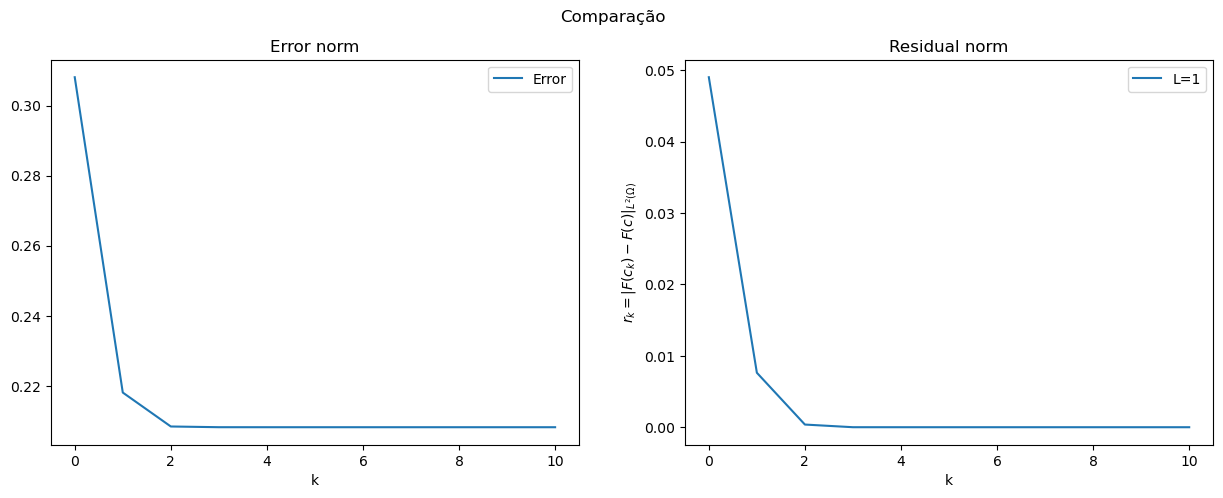

In [49]:
gamma_norm = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(inv_problem.gamma_inv, inv_problem.gamma_inv)*ufl.dx)).real**0.5
U_norm = np.linalg.norm(np.array(U_list).flatten())

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(err_array/gamma_norm,label='Error')
ax[0].set_title("Error norm")
ax[0].set_xlabel("k")
# ax[0].set_yscale("log")
ax[0].legend()

ax[1].plot(res_array/U_norm,label ='L=1')
ax[1].set_title("Residual norm")
ax[1].set_ylabel("$r_k = \|F(c_k) - F(c)\|_{L^2(\Omega)}$")
ax[1].set_xlabel("k")
# ax[1].set_yscale("log")
ax[1].legend()

fig.suptitle("Comparação")

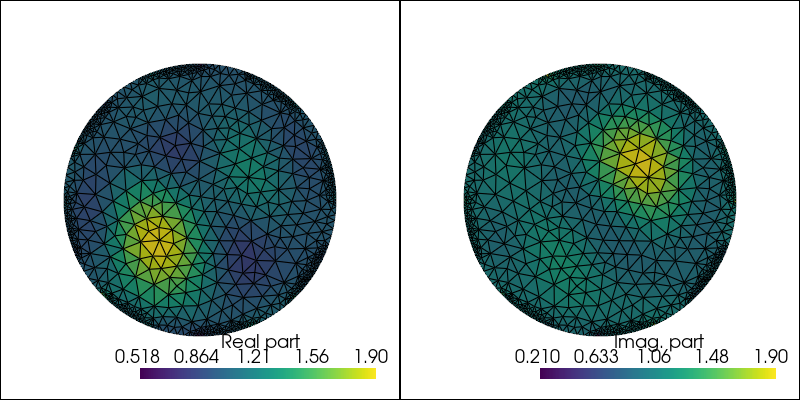

In [50]:
eitx.plot_indicator_function(gamma)